<img src="imgs/mioti_empire.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S4: Data augmentation

`General, sabemos que quiere dejar las trincheras para pasar a su nuevo cargo de LORD DE LOS DATOS en el IMPERIO GALÁCTICO. Está usted a prueba para un sistema crítico para el IMPERIO GALÁCTICO, pues después de las incursiones en Scarif, debemos proceder con un método de detección de transmisiones enemigas dentro de nuestra órbita. Esta será su carta de presentación.`

`Para ello, se le dispondrá de un set de datos extraído de los últimos intentos de ataque en nuestro silo de planos de armas secretas. Estos datos muestran obviamente y gracias al trabajo del antiguo general al mando, ya *jubilado*, un problema grave de desbalanceo en cuanto a tipología de los datos, así que será su labor trabajar con ellos para conseguir un balanceo orden y deacuerdo a las directrices del glorioso IMPERIO GALÁCTICO.`

`Como primera tarea, se le solicita un primer vistazo a los datos.`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

import random
from imblearn.under_sampling import RandomUnderSampler
random.seed(1234)

tr = pd.read_csv("data/transmission_small.csv")

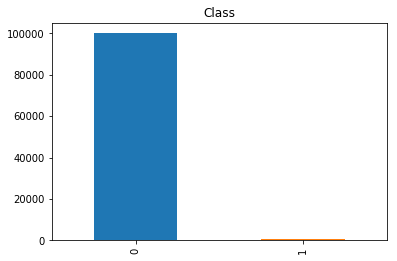

In [2]:
tr['Class'].value_counts().plot(kind='bar', title='Class')

`Se necesita entender la magnitud del problema. Informe del posible desbalanceo de los datos, tanto por escrito como mediante la gráfica que usted considere oportuna`

In [3]:
tr.head()

V1        V2  Class
0  2.049094  0.186189      0
1  2.125540 -0.030714      0
2 -4.155859 -5.705748      0
3 -0.566420 -0.579576      0
4  0.060858 -0.261762      0

In [4]:
tr['Class'].value_counts()

0    100000
1       492
Name: Class, dtype: int64

`También deberá conocer en qué rango se manejan los datos y con qué estamos trabajando. Una gráfica de puntos podría ser lo más adecuado ahora.`

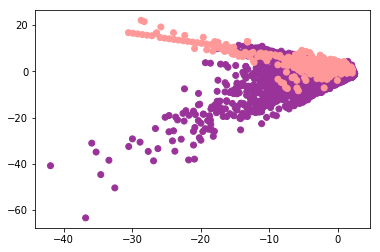

In [5]:
colors = tr['Class'].map({0 : "#993399", 1: "#ff9999"})
plt.scatter(x = tr['V1'], y = tr['V2'], c=colors)

`Le proponemos ahora una función sencilla para evaluar su sistema de mejora de los datos. Esta función no deberá modificarse y como único requisito deberá de suministrar los datos como parámetro.`

In [6]:
def evaluar_sistema(data_variables, class_variable):
    # Recibe:
    # - data_variables: dataframe con dos columnas siendo estas las variables de datos.
    # - class_variable: dataframe con una columna siendo esta la clase de transmisión.
    # Imprime:
    # - puntuación de clasificación.
    print("Evaluando...")
    clf = LinearSVC().fit(data_variables, class_variable.values.ravel())
    predicted = clf.predict(data_variables)
    
    puntos = 0
    for ci, pi in zip(class_variable.values.ravel(), predicted):
        if ci != pi:
            n = 1 if ci == 0 else 50
        else:
            n = 0
        puntos += n
        
    print("Puntuación obtenida: {} (más alta es peor)".format(puntos))

***

`Ahora el trabajo es todo suyo, General. Deberá trabajar con nuestros datos y conseguir disminuir esa puntuación al máximo posible. Documente todos los pasos e incluya de sus valoraciones al final del informe.`

1. Quitaremos el máximo posible de vecinos de la clase mayoritaria con la minoritaria.

Filas que nos quedamos: 91268


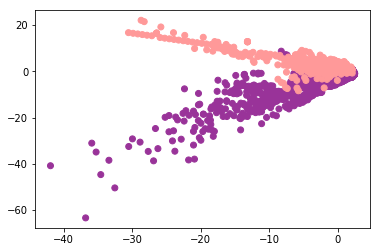

In [7]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors = 50, random_state=0)
enn.fit_sample(tr[['V1', 'V2']], tr[['Class']].values.ravel())
print('Filas que nos quedamos:', len(enn.sample_indices_))

tr_enn = tr.iloc[enn.sample_indices_]
colors = tr_enn['Class'].map({0 : "#993399", 1: "#ff9999"})
plt.scatter(x = tr_enn['V1'], y = tr_enn['V2'], c=colors)

In [8]:
tr_enn['Class'].value_counts()

0    90776
1      492
Name: Class, dtype: int64

2. Tras esto, haremos un random undersampling para quitar aleatoriamente datos de la clase mayoritaria e igualarla con la minoritaria.

In [9]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 0)
rus.fit_sample(tr_enn[['V1', 'V2']], tr_enn[['Class']].values.ravel())
print('Filas que nos quedamos:', len(rus.sample_indices_))
alerts_undersampled = tr_enn.iloc[rus.sample_indices_]

Filas que nos quedamos: 984


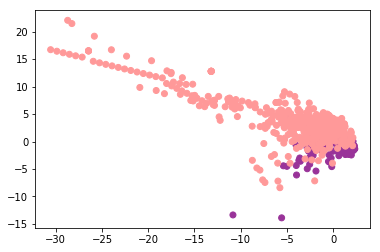

In [10]:
colors = alerts_undersampled['Class'].map({0 : "#993399", 1: "#ff9999"})
plt.scatter(x = alerts_undersampled['V1'], y = alerts_undersampled['V2'], c=colors)

In [11]:
alerts_undersampled['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

3. Una vez tenemos ambas clases igualadas, volveremos a quitar los vecinos cercanos para así eliminar los datos que se encuentran más cercanos y que no haya lugar a confusión.

Filas que nos quedamos: 641


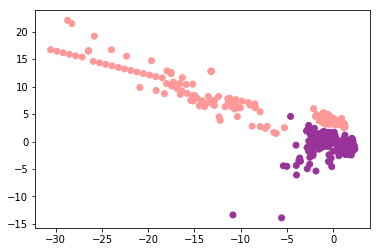

In [12]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors = 50, random_state=0)
enn.fit_sample(alerts_undersampled[['V1', 'V2']], alerts_undersampled[['Class']].values.ravel())
print('Filas que nos quedamos:', len(enn.sample_indices_))

tr_enn2 = alerts_undersampled.iloc[enn.sample_indices_]
colors = tr_enn2['Class'].map({0 : "#993399", 1: "#ff9999"})
plt.scatter(x = tr_enn2['V1'], y = tr_enn2['V2'], c=colors)

In [13]:
tr_enn2['Class'].value_counts()

0    492
1    149
Name: Class, dtype: int64

3. En último lugar, para balancear ambas clases, realizaremos un oversampling de la clase minoritaria. Como hay algunos datos que son difíciles de identificar, se ha elegido Adasyn.

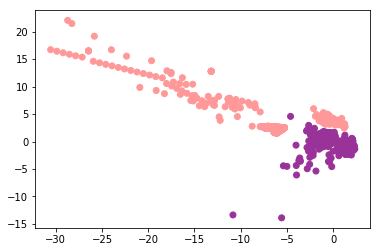

In [14]:
from imblearn.over_sampling import ADASYN
ada = ADASYN()
X, y = ada.fit_sample(tr_enn2[['V1', 'V2']], tr_enn2[['Class']].values.ravel())

# convertimos a DataFrame por comodidad y renombramos las columnas de datos en X a los nombres que teníamos previamente.
alerts_ada = pd.DataFrame(X).rename(columns = {0 : 'V1', 1 : 'V2'})
alerts_ada['Class'] = y

colors = alerts_ada['Class'].map({0 : "#993399", 1: "#ff9999"})
plt.scatter(x = alerts_ada['V1'], y = alerts_ada['V2'], c=colors)


In [15]:
alerts_ada['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

#### Evaluamos el sistema

In [16]:
evaluar_sistema(alerts_ada[['V1', 'V2']], alerts_ada[['Class']])

Evaluando...
Puntuación obtenida: 208 (más alta es peor)


¿Has logrado proteger al Imperio Galáctico de transmisiones enemigas? ¿O has tenido problemas de "jubilación"?
* ¿Qué problemas ves a estos métodos de data augmentation?

En los métodos de undersampling hay un principal problema, que es la pérdida de datos; mientras que para las técnicas de oversampling el problema es que estamos añadiendo datos fictios, lo que puede añadir ruido en nuestro dataset.


* ¿Qué crees que es más razonable cuando te enfrentas a un problema de este tipo?

Tener una estrategia clara de lo que se quiere conseguir y combinar ambos métodos en función de ello.


* La función de evaluación del sistema penaliza con un punto si la clase predecida es de valor 1 pero 50 puntos si la clase predecida es de valor 0. ¿Por qué crees que pasa esto?

La clase mayoritaria era la clase 0, por lo que tiene sentido que penalice con más puntos si se predice esta clase ya que significará que el dataset seguirá desbalanceado (el objetivo era balancearlo).

***

### Punto extra

`Como tarea final, se le exige que nos facilite una identificación. Muestre su rostro real y provea al IMPERIO GALÁCTICO de datos suficientes para poder identificale desde todos los ángulos posibles una vez pase a formar parte de nuestro equipo de datos. Se requiere un mínimo de 5 ejemplos de su rostro para entrenar correctamente el sistema y que nuestras medidas de seguridad no cometan el error de considerarlo una amenaza.`

In [17]:
from skimage import io, transform
from skimage.color import rgb2gray
import numpy as np
selfie = io.imread("selfie.jpg")
print("Dimensión Y: {}, Dimensión X: {}, Canales: {}".format(selfie.shape[0], selfie.shape[1], selfie.shape[2]))

Dimensión Y: 417, Dimensión X: 626, Canales: 3


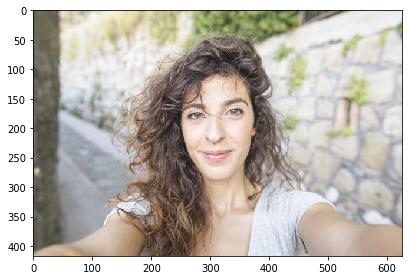

In [18]:
io.imshow(selfie)

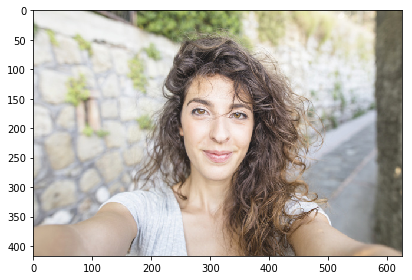

In [19]:
#Invertimos la imagen
io.imshow(np.fliplr(selfie))

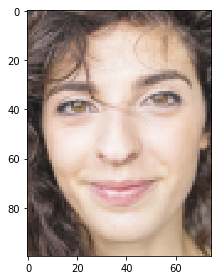

In [20]:
#Haremos zoom de la imagen
startx = 240
starty = 100    
cropped = selfie[starty:starty+200,startx:startx+140, :]
io.imshow(transform.resize(cropped, (100, 75)))

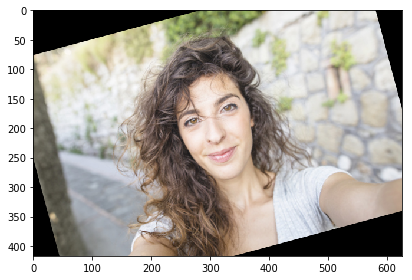

In [21]:
io.imshow(transform.rotate(selfie, 15, resize=False))

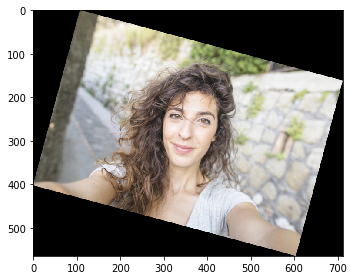

In [22]:
io.imshow(transform.rotate(selfie, -15, resize=True))

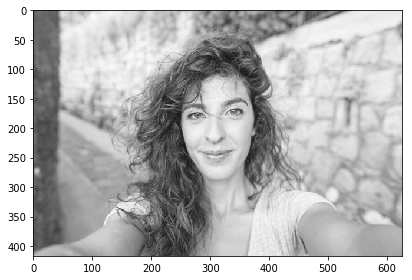

In [23]:
io.imshow(rgb2gray(selfie))